## 1. Import Library

In [0]:
# Import library
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

## 2.  Load Dataset

In [2]:
# Load data
# Colab library to upload files to notebook, Ref:https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Load data from Kaggle to Google Colab virtual machine
os.environ['KAGGLE_USERNAME'] = "emilyhsucr" # username from the json file
os.environ['KAGGLE_KEY'] = "3b6aa5aa02b468c89e4cfac52a5d992e" # key from the json file
!kaggle datasets download -d ahmedmoorsy/facial-expression # api copied from kaggle

 96% 186M/193M [00:03<00:00, 43.7MB/s]
100% 193M/193M [00:03<00:00, 61.9MB/s]


In [0]:
!unzip -q "facial-expression.zip"

In [4]:
#fer2013
# Facial Expression Detection (CNN), Ref: https://www.kaggle.com/shawon10/facial-expression-detection-cnn
filename = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']

fer2013 = pd.read_csv('fer2013.csv')
im=fer2013['pixels']
fer2013.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
def getData(filename):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [6]:
X, Y = getData(filename)
num_class = len(set(Y))
print(num_class)

7


In [0]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

## 3. Build the network

In [9]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [10]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    
    # 1st layer
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    
    # 2nd layer
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 3rd layer
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4th layer
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 5th layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 256)       10

In [14]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
history =model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 25s 781us/step - loss: 1.5878 - acc: 0.3878 - val_loss: 1.7814 - val_acc: 0.3711
Epoch 2/20
32298/32298 [==============================] - 25s 781us/step - loss: 1.2632 - acc: 0.5192 - val_loss: 1.2279 - val_acc: 0.5255
Epoch 3/20
32298/32298 [==============================] - 25s 778us/step - loss: 1.1118 - acc: 0.5843 - val_loss: 1.2238 - val_acc: 0.5386
Epoch 4/20
32298/32298 [==============================] - 25s 762us/step - loss: 0.9922 - acc: 0.6305 - val_loss: 1.1593 - val_acc: 0.5684
Epoch 5/20
32298/32298 [==============================] - 25s 763us/step - loss: 0.8702 - acc: 0.6785 - val_loss: 1.1356 - val_acc: 0.5720
Epoch 6/20
32298/32298 [==============================] - 25s 772us/step - loss: 0.7384 - acc: 0.7312 - val_loss: 1.4124 - val_acc: 0.5397
Epoch 7/20
32298/32298 [==============================] - 25s 787us/step - loss: 0.6123 - acc: 0.7752 - val_loss: 1.2

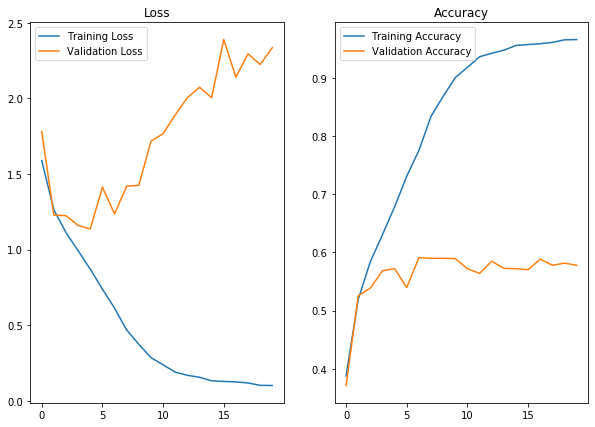

In [15]:
''' Visualize the training/validation loss and training/validation accuracy'''
from pylab import rcParams

rcParams['figure.figsize'] = 10, 7

loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

acc = history.history.get('acc')
val_acc = history.history.get('val_acc')
    
plt.figure(0)

plt.subplot(121)

plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')


plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

In [0]:
# Save model weight
model.save_weights('model_weights_cnnLayer5-01.h5') # HDF5 file

In [0]:
model.save('./model_cnn_5L.t')